# Regressão e Classificação sobre Aluguéis de Imóveis (ZAP Dataset)

In [2]:
import pandas as pd
import numpy as np
import nb_black
import os
import warnings
import seaborn as sns
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    log_loss,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


from sklearn.feature_selection import RFE
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

warnings.filterwarnings("ignore")

%load_ext lab_black

## Métodos

Essa secao ficara todos os metodos e funçoes que serao utilizadas no projeto, a fim de deixar mais organizado e limpo para facilitar o entendimento

In [3]:
def print_shape_dfs(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]

    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath, delimiter=";")
        print(f"{file} -> {df.shape}")

In [4]:
def concat_csv_files(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]
    print_shape_dfs(folder_path)

    dfs = []
    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        temp_df = pd.read_csv(filepath, delimiter=";")
        dfs.append(temp_df)

    df_kaggle = pd.read_csv("dataZAP.csv", delimiter=";")
    dfs.append(df_kaggle)

    all_columns = set().union(*[set(df.columns) for df in dfs])
    dfs = [df.reindex(columns=all_columns) for df in dfs]

    result = pd.concat(dfs, ignore_index=True)
    output_file = os.path.join("./", "dataZap_concatenated.csv")
    result.to_csv(output_file, sep=";", index=False)
    print(f"Shape do df inicial: {df_kaggle.shape}\nShape do df final: {result.shape}")

In [5]:
def check_columns(df):
    check = []
    for column in df.columns:
        types = df[column].apply(type).unique()
        if len(types) > 1:
            if pd.api.types.is_numeric_dtype(df[column]):
                try:
                    converted = pd.to_numeric(df[column], errors="raise")
                except ValueError:
                    check.append(column)
            else:
                check.append(column)

    return check

In [105]:
def get_season(date):
    if date.month >= 1 and date.month <= 3:
        return "Verão"
    elif date.month >= 4 and date.month <= 6:
        return "Outono"
    elif date.month >= 7 and date.month <= 9:
        return "Inverno"
    else:
        return "Primavera"

In [6]:
def remove_outliers(df, num_columns):
    for column in num_columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1

        threshold = 1.5
        lower_limit = Q1 - threshold * IQR
        upper_limit = Q3 + threshold * IQR

        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    return df

In [7]:
def encode_categorical_columns(df, cat_columns):
    encoded_df = df.copy()

    for column in cat_columns:
        encoded_columns = pd.get_dummies(df[column], prefix=column)
        encoded_df = pd.concat([encoded_df, encoded_columns], axis=1)
        encoded_df.drop(column, axis=1, inplace=True)

    return encoded_df

In [8]:
def standardize_columns(df, num_columns):
    standardized_df = df.copy()

    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    standardized_columns = scaler.fit_transform(df[num_columns])
    standardized_df[num_columns] = standardized_columns

    return standardized_df

In [9]:
def evaluate_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("Model testing performance:")
    print("--------------------------")
    print(f"R2_score \t: {round(R2_score, 4)}")
    print(f"MAE \t\t: {round(mae, 4)}")
    print(f"MSE \t\t: {round(mse, 4)}")
    print(f"RMSE \t\t: {round(rmse, 4)}")

In [10]:
def evaluate_regression_metrics(model, X_train, y_train, X_test, y_test, cv=10):
    grid_search = None
    best_params = None

    if model == "LinearRegression":
        regressor = LinearRegression()
    elif model == "Ridge":
        regressor = Ridge()
        param_grid = {"alpha": [0.1, 1.0, 10.0]}
        grid_search = GridSearchCV(
            regressor, param_grid, scoring="neg_mean_squared_error", cv=cv
        )
    elif model == "Lasso":
        regressor = Lasso()
        param_grid = {"alpha": [0.1, 1.0, 10.0]}
        grid_search = GridSearchCV(
            regressor, param_grid, scoring="neg_mean_squared_error", cv=cv
        )
    elif model == "ElasticNet":
        regressor = ElasticNet()
        param_grid = {
            "alpha": [0.1, 1.0, 10.0],
            "l1_ratio": [0.25, 0.5, 0.75],
            "max_iter": [1000, 2000, 3000],
        }
        grid_search = GridSearchCV(
            regressor, param_grid, scoring="neg_mean_squared_error", cv=cv
        )
    elif model == "KNeighborsRegressor":
        regressor = KNeighborsRegressor()
        param_grid = {
            "n_neighbors": [3, 5, 7, 10, 15],
            "weights": ["uniform", "distance"],
        }
        grid_search = GridSearchCV(
            regressor, param_grid, scoring="neg_mean_squared_error", cv=cv
        )
    elif model == "DecisionTreeRegressor":
        regressor = DecisionTreeRegressor()
        param_grid = {"max_depth": [None, 5, 10], "min_samples_split": [2, 5, 10]}
        grid_search = GridSearchCV(
            regressor, param_grid, scoring="neg_mean_squared_error", cv=cv
        )
    else:
        raise ValueError("Modelo não suportado: " + model)

    if grid_search is not None:
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        regressor.set_params(**best_params)

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, rmse, r2, mae, best_params

In [11]:
def define_classification(value):
    lower_bound_low = np.percentile(df["listing.pricingInfo.rentalPrice"], 25)
    upper_bound_low = np.percentile(df["listing.pricingInfo.rentalPrice"], 50)
    lower_bound_medium = np.percentile(df["listing.pricingInfo.rentalPrice"], 50)
    upper_bound_medium = np.percentile(df["listing.pricingInfo.rentalPrice"], 75)

    if value < lower_bound_low:
        return "BAIXO"
    elif value <= upper_bound_medium:
        return "MEDIO"
    else:
        return "ALTO"

In [12]:
def evaluate_classification_metrics(
    model, X_train, y_train, X_test, y_test, cv=10, average="macro"
):
    grid_search = None
    best_params = None

    if model == "LogisticRegression":
        classifier = LogisticRegression(solver="liblinear")
        param_grid = {"C": [0.1, 1.0, 10.0]}
        grid_search = GridSearchCV(classifier, param_grid, scoring="accuracy", cv=cv)
    elif model == "KNeighborsClassifier":
        classifier = KNeighborsClassifier()
        param_grid = {
            "n_neighbors": [3, 5, 7, 10, 15],
            "weights": ["uniform", "distance"],
        }
        grid_search = GridSearchCV(classifier, param_grid, scoring="accuracy", cv=cv)
    elif model == "DecisionTreeClassifier":
        classifier = DecisionTreeClassifier()
        param_grid = {"max_depth": [None, 5, 10], "min_samples_split": [2, 5, 10]}
        grid_search = GridSearchCV(classifier, param_grid, scoring="accuracy", cv=cv)
    elif model == "RandomForest":
        classifier = RandomForestClassifier()
        param_grid = {"n_estimators": [100, 200, 300], "max_depth": [None, 5, 10]}
        grid_search = GridSearchCV(classifier, param_grid, scoring="accuracy", cv=cv)
    elif model == "SVM":
        classifier = SVC()
        param_grid = {"C": [0.1, 1.0, 10.0], "kernel": ["linear", "rbf"]}
        grid_search = GridSearchCV(classifier, param_grid, scoring="accuracy", cv=cv)
    else:
        raise ValueError("Modelo não suportado: " + model)

    if grid_search is not None:
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        classifier.set_params(**best_params)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    return accuracy, precision, recall, f1, best_params

In [13]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    classes = np.unique(y_test)

    fig = sp.make_subplots(rows=1, cols=1)

    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=classes,
            y=classes,
            colorscale="Blues",
            reversescale=True,
            showscale=False,
            hoverongaps=False,
            hovertemplate="Actual: %{y}<br>Predicted: %{x}<br>Count: %{z}<extra></extra>",
        )
    )

    annotations = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            annotations.append(
                dict(
                    x=classes[j],
                    y=classes[i],
                    text=str(cm[i, j]),
                    showarrow=False,
                    font=dict(color="black"),
                )
            )

    fig.update_layout(
        title="Confusion Matrix", width=600, height=500, annotations=annotations
    )

    fig.update_xaxes(title_text="Predicted")
    fig.update_yaxes(title_text="Actual")

    fig.show()

## Webscraping

### Pre-Incrementação

Essa análise abaixo foi necessária para que nosso script de webscraping tenha as mesmas colunas e formato do dataset que está no kaggle, então abaixo foi feito uma análise sobre o shape deles e também sobre quais colunas tem em um e que não tem no outro, até que se chegou no ponto final, que é quando as duas tem o mesmo shape e colunas iguais, que é o output dessa parte.

Isso impactou no código scrap_zap_v3 (nossa versão), pois tive que modificar as colunas que são filtradas e consequentemente criadas o dataframe.

dfc = dataset do kaggle

dfx = um dos datasets que o webscraping cria

In [553]:
df = pd.read_csv("dataZAP.csv", delimiter=";")
df.shape

(35772, 78)

In [81]:
df_aux = pd.read_csv(
    "webscraping-datasets/dataZap_ce_aluguel_casas_TODOS_3.csv", delimiter=";"
)
df_aux.shape

(352, 78)

In [82]:
dfc = []
for i in df.columns:
    dfc.append(i)

dfx = []
for i in df_aux.columns:
    dfx.append(i)

dfc = set(dfc)
dfx = set(dfx)

In [83]:
len(dfc.intersection(dfx))

78

In [84]:
list(dfc - dfx)

[]

In [85]:
list(dfx - dfc)

[]

Conclusao: Dessa forma final, todas os dataframes que forem realizados pelo webscraping terao as mesmas colunas e quantidades que o dataset do kaggle, facilitando a incrementacao dos dados via scraping.

### Utilização do Script de WebScraping

O site do ZAP tem uma 'proteção' http por scraping, então o excesso de requisições ele acaba bloqueando por alguns minutos para uma outra nova requisição 

In [10]:
!python ./webscraping/scrap_zap_v3.py

TODOS -> TODOS -> rj -> casas -> 4
https://www.zapimoveis.com.br/aluguel/casas/rj/4-quartos/?pagina=52&precoMinimo=100&precoMaximo=2000000


429

Criando o arquivo dataZAP_aluguel_casas_TODOS.csv com os dados

Arquivo criado

Webscraping finalizado!


### Incrementação do Dataset

In [11]:
concat_csv_files("webscraping-datasets")

dataZap_ba_aluguel_casas_TODOS_3.csv -> (495, 78)
dataZap_ce_aluguel_casas_TODOS_3.csv -> (352, 78)
dataZap_es_aluguel_casas_TODOS_3.csv -> (106, 78)
dataZap_mg_aluguel_casas_TODOS_3.csv -> (1727, 78)
dataZap_rj_aluguel_apartamentos_TODOS_1.csv -> (2799, 78)
dataZap_rj_aluguel_apartamentos_TODOS_2.csv -> (8301, 78)
dataZap_rj_aluguel_apartamentos_TODOS_3.csv -> (4126, 78)
dataZap_rj_aluguel_apartamentos_TODOS_4.csv -> (1565, 78)
dataZap_rj_aluguel_apartamentos_TODOS_5.csv -> (107, 78)
dataZap_rj_aluguel_casas_TODOS_1.csv -> (852, 78)
dataZap_rj_aluguel_casas_TODOS_2.csv -> (1610, 78)
dataZap_rj_aluguel_casas_TODOS_3.csv -> (1227, 78)
dataZap_rj_aluguel_casas_TODOS_4.csv -> (1715, 78)
dataZap_rj_aluguel_casas_TODOS_5.csv -> (449, 78)
dataZap_rj_aluguel_cobertura_TODOS_2.csv -> (217, 78)
dataZap_rj_aluguel_cobertura_TODOS_3.csv -> (590, 78)
dataZap_rj_aluguel_cobertura_TODOS_4.csv -> (643, 78)
dataZap_sp_aluguel_casas_TODOS_3.csv -> (8900, 78)
Shape do df inicial: (35772, 78)
Shape do df

## Data Science

### Pre-processamento

In [207]:
df = pd.read_csv("dataZap_concatenated.csv", delimiter=";")

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71553 entries, 0 to 71552
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   listing.subtitle                      71553 non-null  object
 1   listing.garden                        71553 non-null  bool  
 2   account.licenseNumber                 62336 non-null  object
 3   listing.suites                        66973 non-null  object
 4   listing.bathtub                       71553 non-null  bool  
 5   listing.propertyType                  71553 non-null  object
 6   listing.amenities                     64241 non-null  object
 7   listing.address.level                 71553 non-null  object
 8   listing.listingType                   71553 non-null  object
 9   listing.pricingInfo.businessLabel     71553 non-null  object
 10  listing.pricingInfo.yearlyIptu        60474 non-null  object
 11  listing.pricingInfo.monthlyC

In [209]:
df.describe()

,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.id
count,71553.000000,71553.000000,71553.000000,7.155300e+04
mean,0.318254,0.445069,2.521543,2.515779e+09
std,1.698937,1.982130,1.179905,2.066650e+08
min,0.000000,0.000000,0.000000,4.281836e+07
25%,0.000000,0.000000,2.000000,2.481962e+09
50%,0.000000,0.000000,3.000000,2.490925e+09
75%,0.000000,0.000000,3.000000,2.619714e+09
max,52.000000,102.000000,30.000000,2.634660e+09


In [210]:
df.head()

,listing.subtitle,listing.garden,account.licenseNumber,listing.suites,listing.bathtub,listing.propertyType,listing.amenities,listing.address.level,listing.listingType,listing.pricingInfo.businessLabel,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.address.neighborhood,listing.address.street,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.address.point.lon,listing.hottub,listing.updatedAt,listing.sportcourt,listing.address.precision,listing.advertiserId,listing.acceptExchange,listing.isInactive,listing.pricingInfo.rentalTotalPrice,listing.address.confidence,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.address.point.lat,listing.unitFloor,listing.title,listing.link,listing.bedrooms,listing.unitTypes,account.name,listing.address.zipCode,listing.portal,type,listing.unitSubTypes,listing.businessTypeContext,listing.address.zone,listing.parkingSpaces,listing.preview,listing.description,listing.address.state,listing.address.point.source,listing.bathrooms,listing.pricingInfo.price,listing.pricingInfo.isSale,listing.tenniscourt,listing.legacyId,listing.pricingInfo.period,listing.id,listing.pool,listing.partyhall,listing.createdAt,listing.address.streetNumber,listing.guestpark,listing.barbgrill,listing.publicationType,listing.pricingInfo.salePrice,listing.playground,listing.externalId,listing.pricingInfo.businessType,listing.usableAreas,listing.backyard,listing.displayAddressType,listing.address.country,listing.fireplace,listing.gym,listing.address.city,listing.floors,imvl_type,listing.usageTypes,listing.mountainview,listing.sauna
0,Casa para alugar em,True,NaN,3.0,False,UNIT,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,CITY,USED,Alugar,NaN,700.0,True,Guarajuba Monte Gordo,Rua Arraia,900.0,3.0,NaN,False,2023-01-12T08:50:05.990Z,True,APPROXIMATE,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,False,False,NaN,VALID_STREET,False,True,0,NaN,0,Casa para aluguel frente a praia em Guarajuba ...,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,3,HOME,Hansen Imóveis Ltda,42840492.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,2.0,False,Sua ampla e super ventilada cozinha americana ...,Bahia,NaN,5,3.000,False,True,NaN,dia,2552533354,False,True,2022-02-22T19:17:45.103Z,NaN,False,True,SUPER_PREMIUM,NaN,False,CO562A,RENTAL,300,False,STREET,BR,False,False,Camaçari,NaN,casas,RESIDENTIAL,False,False
1,Casa para alugar em,False,NaN,1.0,False,UNIT,KITCHEN|INTERCOM|SERVICE_AREA,STREET,USED,Alugar,161.0,NaN,True,Nazaré,NaN,183.0,3.0,NaN,False,2023-05-05T10:02:17.022Z,False,ROOFTOP,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,False,False,NaN,VALID_STREET,False,False,0,NaN,0,"Casa com 3 Dormitórios para Alugar, 183 m² por...",/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,3,HOME,Adriana Silva dos Santos,40050330.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,0.0,False,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,Bahia,NaN,3,3.000,False,False,NaN,mês,2628408803,False,False,2023-04-26T00:14:08.546Z,NaN,False,False,SUPER_PREMIUM,NaN,False,CA0218,RENTAL,183,False,NEIGHBORHOOD,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
2,Casa para alugar e comprar em,False,14268-J-BA,2.0,False,UNIT,NaN,STREET,USED,Alugar/Comprar,260.0,NaN,True,Pituba,Rua Anthenor Tupinambá,1000.0,7.5,-38.451315,False,2023-04-29T21:40:00.231Z,False,GEOMETRIC_CENTER,42074fd8-9c4d-fb59-a874-b1dcb90c6890,False,False,NaN,VALID_STREET,False,False,0,-12.992829,1,Casa Ampla em Pituba - Salvador,/imovel/venda-casa-3-quartos-pituba-salvador-b...,3,HOME,ISLV IMÓVEIS,41810680.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,7.0,False,"Casa ampla , situado em uma rua residencial. p...",Bahia,GOOGLE,3,7.500,True,False,NaN,mês,2616700504,False,False,2023-03-04T14:04:38.655Z,NaN,False,False,SUPER_PREMIUM,1.300.000,False,741,RENTAL_SALE,300,False,ALL,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
3,Casa para alugar em,False,NaN,1.0,False,UNIT,NaN,STREET,USED,Alugar,NaN,NaN,True,Gleba A,Avenida Concêntrica,NaN,1.8,-38

In [211]:
df.isna().sum()

listing.subtitle             0
listing.garden               0
account.licenseNumber     9217
listing.suites            4580
listing.bathtub              0
                         ...  
listing.floors           29866
imvl_type                    0
listing.usageTypes           0
listing.mountainview         0
listing.sauna                0
Length: 78, dtype: int64

#### Analisando as colunas

In [212]:
columns = [
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
]
df[columns]

,listing.pricingInfo.isRent,listing.pricingInfo.isSale,listing.pricingInfo.price,listing.pricingInfo.rentalPrice,listing.pricingInfo.rentalTotalPrice,listing.pricingInfo.salePrice
0,True,False,3.000,3.0,NaN,NaN
1,True,False,3.000,3.0,NaN,NaN
2,True,True,7.500,7.5,NaN,1.300.000
3,True,False,1.800,1.8,NaN,NaN
4,True,False,1.800,1.8,NaN,NaN
...,...,...,...,...,...,...
71548,True,False,1.8,1.8,2.720,normal
71549,True,False,1.19,1.19,1.434,normal
71550,True,False,940.0,940.0,1.054,normal
71551,True,False,1.6,1.6,2.294,normal


In [213]:
df["listing.pricingInfo.rentalTotalPrice"].isna().sum()

17945

In [214]:
df["listing.pricingInfo.price"].isna().sum()

0

In [215]:
df[(df["listing.pricingInfo.isRent"] == True)]

,listing.subtitle,listing.garden,account.licenseNumber,listing.suites,listing.bathtub,listing.propertyType,listing.amenities,listing.address.level,listing.listingType,listing.pricingInfo.businessLabel,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.address.neighborhood,listing.address.street,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.address.point.lon,listing.hottub,listing.updatedAt,listing.sportcourt,listing.address.precision,listing.advertiserId,listing.acceptExchange,listing.isInactive,listing.pricingInfo.rentalTotalPrice,listing.address.confidence,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.address.point.lat,listing.unitFloor,listing.title,listing.link,listing.bedrooms,listing.unitTypes,account.name,listing.address.zipCode,listing.portal,type,listing.unitSubTypes,listing.businessTypeContext,listing.address.zone,listing.parkingSpaces,listing.preview,listing.description,listing.address.state,listing.address.point.source,listing.bathrooms,listing.pricingInfo.price,listing.pricingInfo.isSale,listing.tenniscourt,listing.legacyId,listing.pricingInfo.period,listing.id,listing.pool,listing.partyhall,listing.createdAt,listing.address.streetNumber,listing.guestpark,listing.barbgrill,listing.publicationType,listing.pricingInfo.salePrice,listing.playground,listing.externalId,listing.pricingInfo.businessType,listing.usableAreas,listing.backyard,listing.displayAddressType,listing.address.country,listing.fireplace,listing.gym,listing.address.city,listing.floors,imvl_type,listing.usageTypes,listing.mountainview,listing.sauna
0,Casa para alugar em,True,NaN,3.0,False,UNIT,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,CITY,USED,Alugar,NaN,700.0,True,Guarajuba Monte Gordo,Rua Arraia,900.0,3.0,NaN,False,2023-01-12T08:50:05.990Z,True,APPROXIMATE,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,False,False,NaN,VALID_STREET,False,True,0,NaN,0,Casa para aluguel frente a praia em Guarajuba ...,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,3,HOME,Hansen Imóveis Ltda,42840492.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,2.0,False,Sua ampla e super ventilada cozinha americana ...,Bahia,NaN,5,3.000,False,True,NaN,dia,2552533354,False,True,2022-02-22T19:17:45.103Z,NaN,False,True,SUPER_PREMIUM,NaN,False,CO562A,RENTAL,300,False,STREET,BR,False,False,Camaçari,NaN,casas,RESIDENTIAL,False,False
1,Casa para alugar em,False,NaN,1.0,False,UNIT,KITCHEN|INTERCOM|SERVICE_AREA,STREET,USED,Alugar,161.0,NaN,True,Nazaré,NaN,183.0,3.0,NaN,False,2023-05-05T10:02:17.022Z,False,ROOFTOP,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,False,False,NaN,VALID_STREET,False,False,0,NaN,0,"Casa com 3 Dormitórios para Alugar, 183 m² por...",/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,3,HOME,Adriana Silva dos Santos,40050330.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,0.0,False,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,Bahia,NaN,3,3.000,False,False,NaN,mês,2628408803,False,False,2023-04-26T00:14:08.546Z,NaN,False,False,SUPER_PREMIUM,NaN,False,CA0218,RENTAL,183,False,NEIGHBORHOOD,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
2,Casa para alugar e comprar em,False,14268-J-BA,2.0,False,UNIT,NaN,STREET,USED,Alugar/Comprar,260.0,NaN,True,Pituba,Rua Anthenor Tupinambá,1000.0,7.5,-38.451315,False,2023-04-29T21:40:00.231Z,False,GEOMETRIC_CENTER,42074fd8-9c4d-fb59-a874-b1dcb90c6890,False,False,NaN,VALID_STREET,False,False,0,-12.992829,1,Casa Ampla em Pituba - Salvador,/imovel/venda-casa-3-quartos-pituba-salvador-b...,3,HOME,ISLV IMÓVEIS,41810680.0,GRUPOZAP,superPremium,NaN,RENTAL,Bairros,7.0,False,"Casa ampla , situado em uma rua residencial. p...",Bahia,GOOGLE,3,7.500,True,False,NaN,mês,2616700504,False,False,2023-03-04T14:04:38.655Z,NaN,False,False,SUPER_PREMIUM,1.300.000,False,741,RENTAL_SALE,300,False,ALL,BR,False,False,Salvador,NaN,casas,RESIDENTIAL,False,False
3,Casa para alugar em,False,NaN,1.0,False,UNIT,NaN,STREET,USED,Alugar,NaN,NaN,True,Gleba A,Avenida Concêntrica,NaN,1.8,-38

In [216]:
df["listing.pricingInfo.businessType"].value_counts()

RENTAL         55205
RENTAL_SALE    14290
SALE_RENTAL     2058
Name: listing.pricingInfo.businessType, dtype: int64

In [217]:
df["listing.displayAddressType"].value_counts()

ALL             38083
STREET          22388
NEIGHBORHOOD    11082
Name: listing.displayAddressType, dtype: int64

In [218]:
df["listing.isInactive"].value_counts()

False    70994
True       559
Name: listing.isInactive, dtype: int64

In [219]:
df["listing.floors"].unique()  # Valores mistos que serão tratados

array([nan, 0.0, 1.0, 3.0, 2.0, 6.0, 12.0, 17.0, 4.0, 10.0, 15.0, 11.0,
       5.0, 8.0, 13.0, 9.0, 16.0, 20.0, 14.0, 7.0, 25.0, 18.0, 26.0, 21.0,
       23.0, 24.0, 22.0, 32.0, 114.0, 19.0, 30.0, 29.0, 28.0, 175.0, 71.0,
       '28.0', '0.0', '3.0', '1.0', '2.0', '6.0', '14.0', '71.0',
       'normal', '2', '21', '10', '13', '15', '12', '4', '20', '6', '8',
       '3', '11', '28', '23', '9', '16', '14', '24', '30', '5', '17',
       '22', '27', '19', '1', '7', '35', '18', '25', '26', '660', '175',
       '31', '32', '33'], dtype=object)

In [220]:
df["listing.totalAreas"].unique()  # Valores mistos que serão tratados

array([900.0, 183.0, 1000.0, ..., '1778', '3600', '1108'], dtype=object)

In [221]:
# Tirando as colunas que nao importam para nossa analise

columns = [
    "listing.address.streetNumber",
    "Page",
    "account.legacyVivarealId",
    "account.legacyZapId",
    "listing.address.geoJson",
    "account.licenseNumber",
    "listing.address.ibgeCityId",
    "listing.id",
    "listing.legacyId",
    "listing.pricingInfo.priceVariation",
    "listing.description",
    "listing.images",
    "listing.videos",
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
    "listing.unitSubTypes",
    "listing.amenities",
    "account.logoUrl",
    "account.name",
    "link.href",
    "listing.subtitle",
    "listing.title",
    "listing.portal",
    "listing.createdAt",
    "listing.externalId",
    "listing.advertiserId",
    "listing.address.street",
    "listing.address.point.lon",
    "listing.address.point.lat",
    "listing.address.precision",
    "listing.videoTour",
    "listing.address.point.source",
    "listing.address.country",
    "listing.address.confidence",
    "listing.publicationType",
    "listing.pricingInfo.businessType",
    "listing.address.state",
    "listing.listingType",
    "listing.link",
    "listing.propertyType",
    "listing.pricingInfo.businessLabel",
    "listing.isInactive",
    "listing.preview",
    "listing.pricingInfo.period",
    "listing.displayAddressType",
    "listing.acceptExchange",
    "listing.businessTypeContext",
    "listing.usageTypes",
    "listing.address.level",
    "listing.unitTypes",
    "type",
    "listing.address.zipCode",
    # "listing.updatedAt",
]

lista_columns = []
for df_columns in df.columns:
    lista_columns.append(df_columns)

for column in columns:
    if column in lista_columns:
        df.drop(columns=column, axis=1, inplace=True)

In [222]:
df.shape

(71553, 34)

#### Limitando a regiao de interesse

Consideramos que a regiao importa para o calculo do modelo de previsao. Entao para isso, iremos fazer um filtro para que a nossa previsao seja mais fidedigna possivel com os valores apresentados. Dessa forma, vamos fazer a analise do preço de aluguel para o estado do Rio de Janeiro

In [223]:
pd.options.display.max_columns = 99
column_filter = df["listing.address.city"] == "Rio de Janeiro"
df = df[column_filter]

In [224]:
df.isna().sum()

listing.garden                             0
listing.suites                          2209
listing.bathtub                            0
listing.pricingInfo.yearlyIptu          5011
listing.pricingInfo.monthlyCondoFee     3096
listing.address.neighborhood               0
listing.totalAreas                      1746
listing.pricingInfo.rentalPrice            0
listing.hottub                             0
listing.updatedAt                          0
listing.sportcourt                         0
listing.soundproofing                      0
listing.furnished                          0
listing.unitsOnTheFloor                    0
listing.unitFloor                          0
listing.bedrooms                           0
listing.address.zone                       0
listing.parkingSpaces                   1732
listing.bathrooms                          0
listing.tenniscourt                        0
listing.pool                               0
listing.partyhall                          0
listing.gu

In [225]:
df.drop(columns="listing.address.city", axis=1, inplace=True)

#### Tirando valores repetidos do nosso dataset

In [226]:
print(f"Antes de tirar duplicates: {df.shape}")

Antes de tirar duplicates: (19041, 33)


In [227]:
df.drop_duplicates(inplace=True)

In [228]:
print(f"Depois: {df.shape}")

Depois: (17695, 33)


#### Completando (Fill) os valores nulos

In [229]:
# Como nao pode ter casa sem piso, sera transformado em 1 quando nulo
df["listing.floors"] = df["listing.floors"].fillna(1)

# Valor de iptu nula, deve ser sem iptu
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].fillna(0)

# Vaga de estacionamento nula, deve ser sem vagas
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].fillna(0)

# Area total nula, vamos admitir que é o mesmo tamanho da area usavel
df["listing.totalAreas"] = df["listing.totalAreas"].fillna(df["listing.usableAreas"])

In [230]:
df.isna().sum()

listing.garden                            0
listing.suites                         2162
listing.bathtub                           0
listing.pricingInfo.yearlyIptu            0
listing.pricingInfo.monthlyCondoFee    3044
listing.address.neighborhood              0
listing.totalAreas                        0
listing.pricingInfo.rentalPrice           0
listing.hottub                            0
listing.updatedAt                         0
listing.sportcourt                        0
listing.soundproofing                     0
listing.furnished                         0
listing.unitsOnTheFloor                   0
listing.unitFloor                         0
listing.bedrooms                          0
listing.address.zone                      0
listing.parkingSpaces                     0
listing.bathrooms                         0
listing.tenniscourt                       0
listing.pool                              0
listing.partyhall                         0
listing.guestpark               

In [231]:
df[df["listing.suites"].isna() == True][
    ["listing.bathrooms", "listing.bedrooms", "listing.suites"]
]

,listing.bathrooms,listing.bedrooms,listing.suites
2683,2,1,NaN
2684,1,1,NaN
2686,2,1,NaN
2689,1,1,NaN
2691,1,1,NaN
...,...,...,...
26542,7,5,NaN
26607,8,5,NaN
26665,7,5,NaN
26761,4,4,NaN


In [232]:
df[["listing.bathrooms", "listing.bedrooms", "listing.suites"]]

,listing.bathrooms,listing.bedrooms,listing.suites
2680,2,1,1.0
2681,1,1,0.0
2682,1,1,0.0
2683,2,1,NaN
2684,1,1,NaN
...,...,...,...
70569,3,3,1
70617,3,3,1
70883,1,1,0
70920,3,3,1


In [233]:
df = df.dropna(subset=["listing.suites"])

In [234]:
df.isna().sum()

listing.garden                            0
listing.suites                            0
listing.bathtub                           0
listing.pricingInfo.yearlyIptu            0
listing.pricingInfo.monthlyCondoFee    2369
listing.address.neighborhood              0
listing.totalAreas                        0
listing.pricingInfo.rentalPrice           0
listing.hottub                            0
listing.updatedAt                         0
listing.sportcourt                        0
listing.soundproofing                     0
listing.furnished                         0
listing.unitsOnTheFloor                   0
listing.unitFloor                         0
listing.bedrooms                          0
listing.address.zone                      0
listing.parkingSpaces                     0
listing.bathrooms                         0
listing.tenniscourt                       0
listing.pool                              0
listing.partyhall                         0
listing.guestpark               

In [235]:
df["listing.pricingInfo.monthlyCondoFee"].value_counts()

normal    328
300       185
500       146
250       140
350       131
         ... 
1.21        1
612.0       1
961.0       1
5.977       1
3.120       1
Name: listing.pricingInfo.monthlyCondoFee, Length: 3082, dtype: int64

In [236]:
df[df["listing.pricingInfo.monthlyCondoFee"] == "normal"][
    [
        "listing.pricingInfo.monthlyCondoFee",
        "listing.pricingInfo.rentalPrice",
        "listing.bedrooms",
    ]
]

,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.rentalPrice,listing.bedrooms
35816,normal,3.1,2
35874,normal,4.0,2
35876,normal,3.0,2
36259,normal,1.5,1
36627,normal,250.0,2
...,...,...,...
69502,normal,1.2,2
69861,normal,28.0,6
69863,normal,17.0,4
70375,normal,1.2,2


In [237]:
df["listing.totalAreas"] = pd.to_numeric(df["listing.totalAreas"], errors="coerce")
df["listing.totalAreas"].replace("normal", pd.NA, inplace=True)

df["listing.totalAreas"].fillna(df["listing.totalAreas"].median(), inplace=True)

In [238]:
df["listing.usableAreas"] = pd.to_numeric(df["listing.usableAreas"], errors="coerce")
df["listing.usableAreas"].replace("normal", pd.NA, inplace=True)

df["listing.usableAreas"].fillna(df["listing.usableAreas"].median(), inplace=True)

In [239]:
df["listing.floors"].replace("normal", pd.NA, inplace=True)

df["listing.floors"].fillna(df["listing.floors"].median(), inplace=True)

In [240]:
df["listing.pricingInfo.yearlyIptu"] = pd.to_numeric(
    df["listing.pricingInfo.yearlyIptu"], errors="coerce"
)
df["listing.pricingInfo.yearlyIptu"].replace("normal", pd.NA, inplace=True)

df["listing.pricingInfo.yearlyIptu"].fillna(
    df["listing.pricingInfo.yearlyIptu"].median(), inplace=True
)

In [241]:
df["listing.suites"] = pd.to_numeric(df["listing.suites"], errors="coerce")
df["listing.suites"].replace("normal", pd.NA, inplace=True)

df["listing.suites"].fillna(df["listing.suites"].median(), inplace=True)

In [242]:
df["listing.parkingSpaces"] = pd.to_numeric(
    df["listing.parkingSpaces"], errors="coerce"
)
df["listing.parkingSpaces"].replace("normal", pd.NA, inplace=True)

df["listing.parkingSpaces"].fillna(df["listing.parkingSpaces"].median(), inplace=True)

In [243]:
df["listing.pricingInfo.monthlyCondoFee"].replace("normal", pd.NA, inplace=True)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].str.replace(".", "", regex=True)
df["listing.pricingInfo.monthlyCondoFee"] = pd.to_numeric(
    df["listing.pricingInfo.monthlyCondoFee"], errors="coerce"
).astype(float)
df["listing.pricingInfo.monthlyCondoFee"].fillna(
    df["listing.pricingInfo.monthlyCondoFee"].median(), inplace=True
)

In [244]:
df["listing.pricingInfo.rentalPrice"] = pd.to_numeric(
    df["listing.pricingInfo.rentalPrice"], errors="coerce"
)
df["listing.pricingInfo.rentalPrice"].fillna(
    df["listing.pricingInfo.rentalPrice"].median(), inplace=True
)

In [245]:
df.isna().sum()

listing.garden                         0
listing.suites                         0
listing.bathtub                        0
listing.pricingInfo.yearlyIptu         0
listing.pricingInfo.monthlyCondoFee    0
listing.address.neighborhood           0
listing.totalAreas                     0
listing.pricingInfo.rentalPrice        0
listing.hottub                         0
listing.updatedAt                      0
listing.sportcourt                     0
listing.soundproofing                  0
listing.furnished                      0
listing.unitsOnTheFloor                0
listing.unitFloor                      0
listing.bedrooms                       0
listing.address.zone                   0
listing.parkingSpaces                  0
listing.bathrooms                      0
listing.tenniscourt                    0
listing.pool                           0
listing.partyhall                      0
listing.guestpark                      0
listing.barbgrill                      0
listing.playgrou

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15533 entries, 2680 to 71193
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.garden                       15533 non-null  bool   
 1   listing.suites                       15533 non-null  float64
 2   listing.bathtub                      15533 non-null  bool   
 3   listing.pricingInfo.yearlyIptu       15533 non-null  float64
 4   listing.pricingInfo.monthlyCondoFee  15533 non-null  float64
 5   listing.address.neighborhood         15533 non-null  object 
 6   listing.totalAreas                   15533 non-null  float64
 7   listing.pricingInfo.rentalPrice      15533 non-null  float64
 8   listing.hottub                       15533 non-null  bool   
 9   listing.updatedAt                    15533 non-null  object 
 10  listing.sportcourt                   15533 non-null  bool   
 11  listing.soundproofing    

#### Definindo a questão de quais são as colunas categoricas e numéricas

In [247]:
df["listing.pricingInfo.rentalPrice"] = df["listing.pricingInfo.rentalPrice"].astype(
    float
)
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(float)
df["listing.floors"] = df["listing.floors"].astype(float)
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].astype(float)
df["listing.unitsOnTheFloor"] = df["listing.unitsOnTheFloor"].astype(float)
df["listing.unitFloor"] = df["listing.unitFloor"].astype(float)

df["listing.bedrooms"] = df["listing.bedrooms"].astype("category")
df["listing.bathrooms"] = df["listing.bathrooms"].astype("category")
df["listing.suites"] = df["listing.suites"].astype("category")
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].astype(
    "category"
)
df["listing.address.zone"] = df["listing.address.zone"].astype("category")
df["imvl_type"] = df["imvl_type"].astype("category")

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15533 entries, 2680 to 71193
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   listing.garden                       15533 non-null  bool    
 1   listing.suites                       15533 non-null  category
 2   listing.bathtub                      15533 non-null  bool    
 3   listing.pricingInfo.yearlyIptu       15533 non-null  float64 
 4   listing.pricingInfo.monthlyCondoFee  15533 non-null  float64 
 5   listing.address.neighborhood         15533 non-null  category
 6   listing.totalAreas                   15533 non-null  float64 
 7   listing.pricingInfo.rentalPrice      15533 non-null  float64 
 8   listing.hottub                       15533 non-null  bool    
 9   listing.updatedAt                    15533 non-null  object  
 10  listing.sportcourt                   15533 non-null  bool    
 11  listing.soun

#### Manutenção dos outliers

In [249]:
len(df["listing.pricingInfo.rentalPrice"].unique())

1280

In [250]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

1822

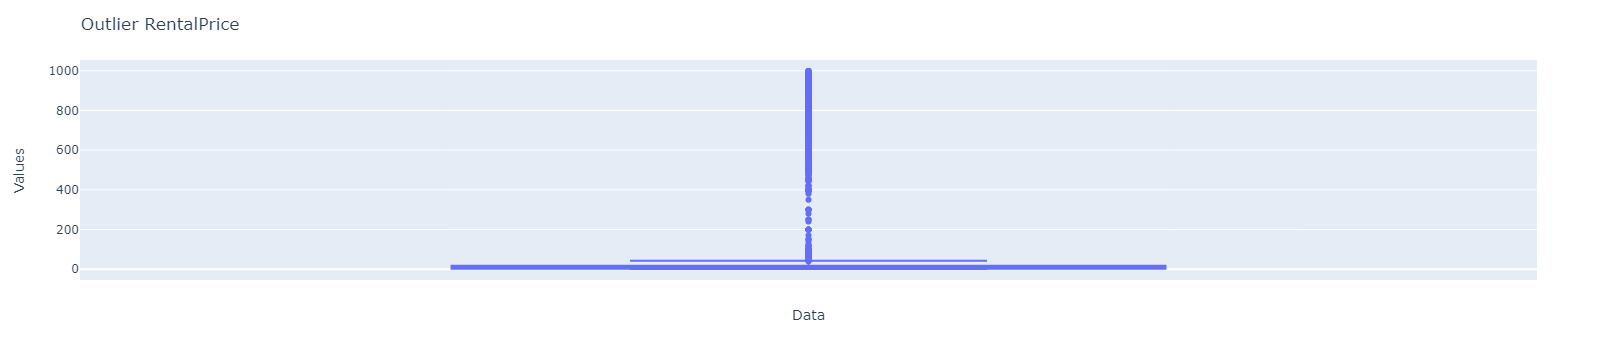

In [251]:
fig = px.box(
    df["listing.pricingInfo.rentalPrice"], y=df["listing.pricingInfo.rentalPrice"]
)
fig.update_layout(
    title="Outlier RentalPrice",
    xaxis=dict(title="Data"),
    yaxis=dict(title="Values"),
    boxmode="group",
    showlegend=False,
)
fig.show()

In [252]:
num_columns = [
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.yearlyIptu",
    "listing.usableAreas",
    "listing.totalAreas",
    "listing.pricingInfo.monthlyCondoFee",
    # "listing.unitFloor",
    # "listing.unitsOnTheFloor",
    # "listing.floors",
    # "listing.parkingSpaces",
]

df = remove_outliers(df, num_columns)

In [253]:
len(df["listing.pricingInfo.rentalPrice"].unique())

824

In [254]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

881

In [255]:
df[["listing.pricingInfo.monthlyCondoFee"]].sort_values(
    "listing.pricingInfo.monthlyCondoFee"
)

,listing.pricingInfo.monthlyCondoFee
14480,168.0
16190,169.0
11687,169.0
13233,170.0
3282,170.0
...,...
5144,1380.0
10290,1380.0
57737,1380.0
14798,1383.0


In [256]:
df[["listing.pricingInfo.yearlyIptu"]].sort_values("listing.pricingInfo.yearlyIptu")

,listing.pricingInfo.yearlyIptu
21068,0.0
8605,0.0
8600,0.0
21465,0.0
21475,0.0
...,...
25993,731.0
26056,731.0
19221,733.0
17468,733.0


In [257]:
df[["listing.pricingInfo.rentalPrice"]].sort_values("listing.pricingInfo.rentalPrice")

,listing.pricingInfo.rentalPrice
21604,1.0
6221,1.0
6225,1.0
12573,1.0
12562,1.0
...,...
12616,40.0
25648,40.0
17538,40.0
26227,40.0


#### Tratamento dos Bairros e Zonas

In [258]:
df["listing.address.zone"].value_counts()

Zona Oeste            2696
Zona Sul              2674
Zona Norte            2306
Zona Central           231
Ilha do Governador     139
Bairros                102
normal                  51
Name: listing.address.zone, dtype: int64

In [259]:
# Ilha do Governador é na Zona Norte do RJ

for i, row in df.iterrows():
    if row["listing.address.zone"] == "Ilha do Governador":
        df.loc[i, "listing.address.zone"] = "Zona Norte"

In [260]:
df["listing.address.zone"].value_counts()

Zona Oeste            2696
Zona Sul              2674
Zona Norte            2445
Zona Central           231
Bairros                102
normal                  51
Ilha do Governador       0
Name: listing.address.zone, dtype: int64

Freguesia e Peninsula ficam na Zona Oeste, Marechal Hermes fica na Zona Norte

In [261]:
for i, row in df.iterrows():
    if row["listing.address.zone"] == "Bairros":
        if row["listing.address.neighborhood"] == "Freguesia":
            df.loc[i, "listing.address.zone"] = "Zona Oeste"
        elif row["listing.address.neighborhood"] == "Peninsula":
            df.loc[i, "listing.address.zone"] = "Zona Oeste"
        elif row["listing.address.neighborhood"] == "Marechal Hermes":
            df.loc[i, "listing.address.zone"] = "Zona Norte"

In [262]:
df["listing.address.zone"].value_counts()

Zona Oeste            2797
Zona Sul              2674
Zona Norte            2446
Zona Central           231
normal                  51
Bairros                  0
Ilha do Governador       0
Name: listing.address.zone, dtype: int64

Drop dos valores que são 'normal'

In [263]:
for i, row in df.iterrows():
    if row["listing.address.zone"] == "normal":
        df.drop(index=i, inplace=True)

#### Tratamento das Datas

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8148 entries, 2680 to 71193
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   listing.garden                       8148 non-null   bool    
 1   listing.suites                       8148 non-null   category
 2   listing.bathtub                      8148 non-null   bool    
 3   listing.pricingInfo.yearlyIptu       8148 non-null   float64 
 4   listing.pricingInfo.monthlyCondoFee  8148 non-null   float64 
 5   listing.address.neighborhood         8148 non-null   category
 6   listing.totalAreas                   8148 non-null   float64 
 7   listing.pricingInfo.rentalPrice      8148 non-null   float64 
 8   listing.hottub                       8148 non-null   bool    
 9   listing.updatedAt                    8148 non-null   object  
 10  listing.sportcourt                   8148 non-null   bool    
 11  listing.sound

In [265]:
df["listing.updatedAt"] = pd.to_datetime(df["listing.updatedAt"])

In [266]:
df["listing.updatedAt"]

2680    2023-05-24 22:22:25.594000+00:00
2681    2023-05-24 13:44:28.197000+00:00
2682    2023-05-25 07:42:59.913000+00:00
2687    2023-04-19 13:15:32.559000+00:00
2688    2023-05-25 07:18:02.153000+00:00
                      ...               
70436   2020-07-08 11:40:02.285000+00:00
70617   2020-07-12 16:05:20.868000+00:00
70883   2020-07-25 21:53:21.267000+00:00
70920   2020-07-29 06:27:49.315000+00:00
71193   2020-07-28 22:33:30.218000+00:00
Name: listing.updatedAt, Length: 8148, dtype: datetime64[ns, UTC]

In [267]:
df["listing.imvl_month"] = df["listing.updatedAt"].dt.month

In [268]:
df["listing.imvl_year"] = df["listing.updatedAt"].dt.year

In [269]:
df["listing.imvl_season"] = df["listing.updatedAt"].apply(get_season)

In [270]:
df["listing.imvl_month"].astype(int)
df["listing.imvl_year"].astype(int)
df["listing.imvl_season"].astype("category")

2680      Outono
2681      Outono
2682      Outono
2687      Outono
2688      Outono
          ...   
70436    Inverno
70617    Inverno
70883    Inverno
70920    Inverno
71193    Inverno
Name: listing.imvl_season, Length: 8148, dtype: category
Categories (4, object): ['Inverno', 'Outono', 'Primavera', 'Verão']

In [271]:
df.drop(columns="listing.updatedAt", inplace=True)

#### Save

In [272]:
df.to_csv("./dataZap_final.csv", sep=";", index=False)

#### Visualização dos Dados

In [273]:
df = pd.read_csv("dataZap_final.csv", delimiter=";")
df.shape

(8148, 35)

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8148 entries, 0 to 8147
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.garden                       8148 non-null   bool   
 1   listing.suites                       8148 non-null   float64
 2   listing.bathtub                      8148 non-null   bool   
 3   listing.pricingInfo.yearlyIptu       8148 non-null   float64
 4   listing.pricingInfo.monthlyCondoFee  8148 non-null   float64
 5   listing.address.neighborhood         8148 non-null   object 
 6   listing.totalAreas                   8148 non-null   float64
 7   listing.pricingInfo.rentalPrice      8148 non-null   float64
 8   listing.hottub                       8148 non-null   bool   
 9   listing.sportcourt                   8148 non-null   bool   
 10  listing.soundproofing                8148 non-null   bool   
 11  listing.furnished             

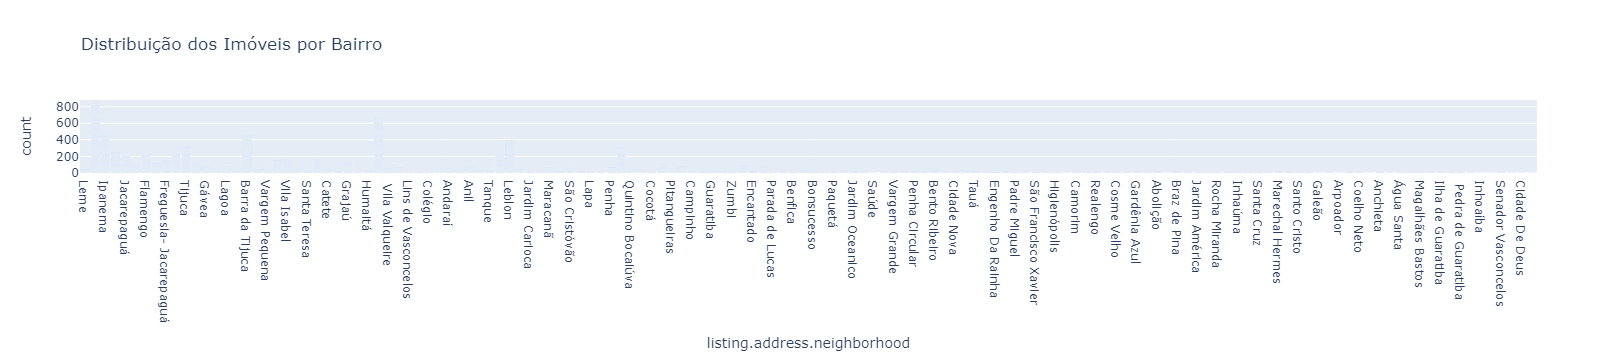

In [275]:
fig = px.bar(
    data_frame=df,
    x="listing.address.neighborhood",
    title="Distribuição dos Imóveis por Bairro",
)
fig.show()

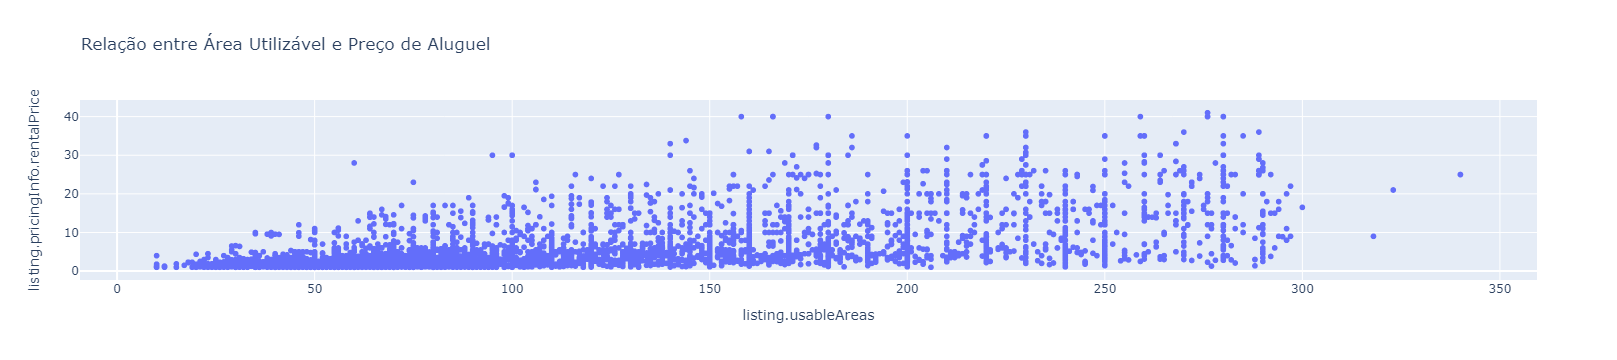

In [276]:
fig = px.scatter(
    data_frame=df,
    x="listing.usableAreas",
    y="listing.pricingInfo.rentalPrice",
    title="Relação entre Área Utilizável e Preço de Aluguel",
)
fig.show()

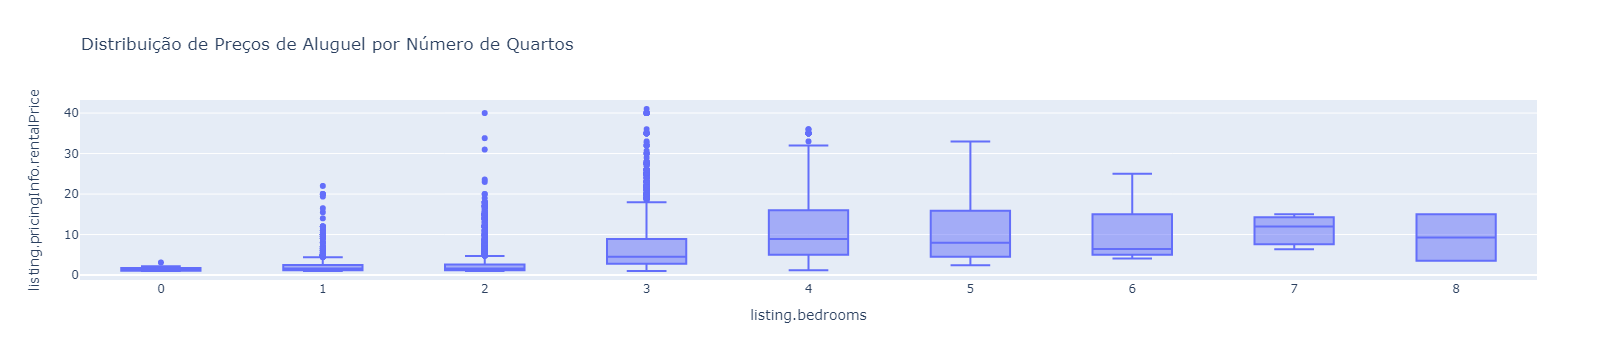

In [277]:
fig = px.box(
    data_frame=df,
    x="listing.bedrooms",
    y="listing.pricingInfo.rentalPrice",
    title="Distribuição de Preços de Aluguel por Número de Quartos",
)
fig.show()

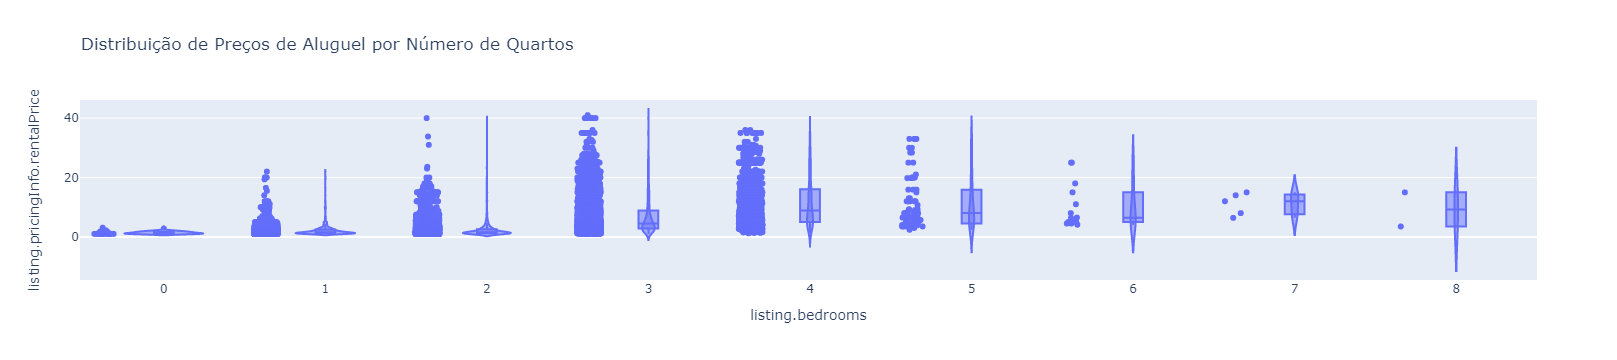

In [278]:
fig = px.violin(
    data_frame=df,
    x="listing.bedrooms",
    y="listing.pricingInfo.rentalPrice",
    box=True,
    points="all",
    title="Distribuição de Preços de Aluguel por Número de Quartos",
)
fig.show()

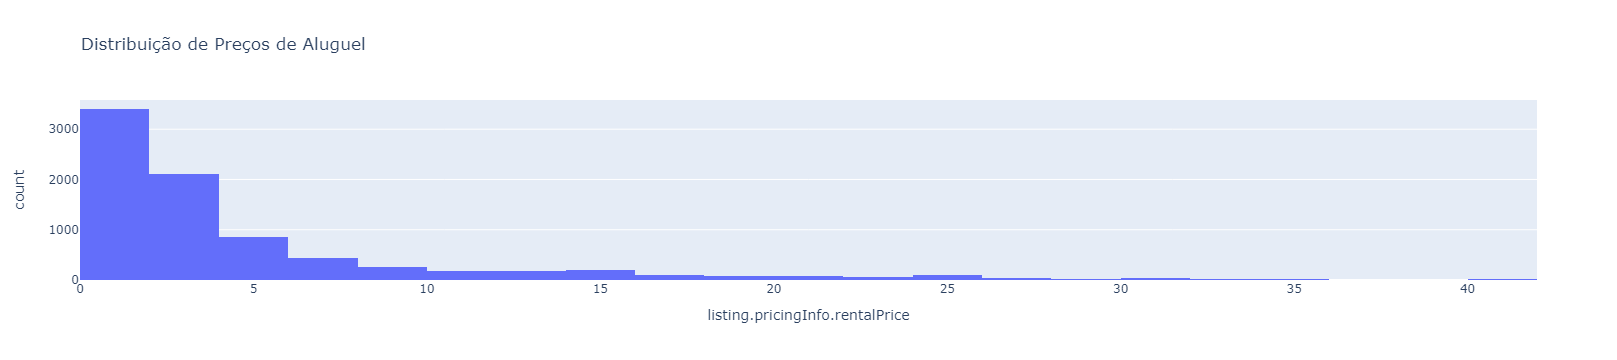

In [279]:
fig = px.histogram(
    data_frame=df,
    x="listing.pricingInfo.rentalPrice",
    nbins=30,
    title="Distribuição de Preços de Aluguel",
)
fig.show()

In [280]:
fig = px.line(
    data_frame=df,
    x="listing.updatedAt",
    y="listing.pricingInfo.rentalPrice",
    title="Tendência dos Preços de Aluguel ao Longo do Tempo",
)
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['listing.garden', 'listing.suites', 'listing.bathtub', 'listing.pricingInfo.yearlyIptu', 'listing.pricingInfo.monthlyCondoFee', 'listing.address.neighborhood', 'listing.totalAreas', 'listing.pricingInfo.rentalPrice', 'listing.hottub', 'listing.sportcourt', 'listing.soundproofing', 'listing.furnished', 'listing.unitsOnTheFloor', 'listing.unitFloor', 'listing.bedrooms', 'listing.address.zone', 'listing.parkingSpaces', 'listing.bathrooms', 'listing.tenniscourt', 'listing.pool', 'listing.partyhall', 'listing.guestpark', 'listing.barbgrill', 'listing.playground', 'listing.usableAreas', 'listing.backyard', 'listing.fireplace', 'listing.gym', 'listing.floors', 'imvl_type', 'listing.mountainview', 'listing.sauna', 'listing.imvl_month', 'listing.imvl_year', 'listing.imvl_season'] but received: listing.updatedAt

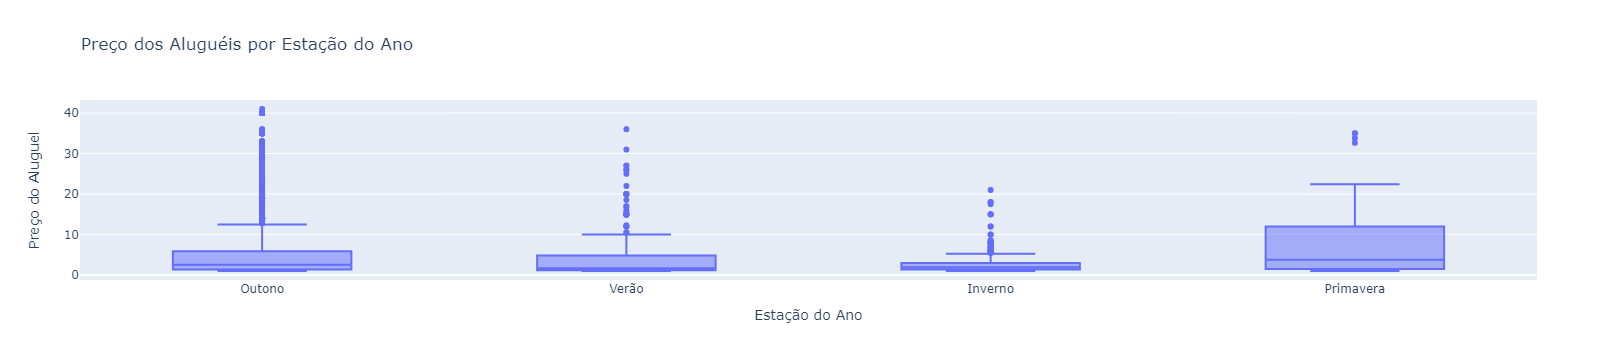

In [281]:
fig = px.box(
    df,
    x="listing.imvl_season",
    y="listing.pricingInfo.rentalPrice",
    title="Preço dos Aluguéis por Estação do Ano",
)
fig.update_layout(xaxis_title="Estação do Ano", yaxis_title="Preço do Aluguel")
fig.show()

#### Selecionar as features baseada na correlação

In [282]:
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(float)
df["listing.floors"] = df["listing.floors"].astype(float)
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].astype(float)
df["listing.unitsOnTheFloor"] = df["listing.unitsOnTheFloor"].astype(float)
df["listing.unitFloor"] = df["listing.unitFloor"].astype(float)

df["listing.bedrooms"] = df["listing.bedrooms"].astype("category")
df["listing.bathrooms"] = df["listing.bathrooms"].astype("category")
df["listing.suites"] = df["listing.suites"].astype("category")
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].astype(
    "category"
)
df["listing.address.zone"] = df["listing.address.zone"].astype("category")
df["imvl_type"] = df["imvl_type"].astype("category")

In [283]:
df.isna().sum()

listing.garden                         0
listing.suites                         0
listing.bathtub                        0
listing.pricingInfo.yearlyIptu         0
listing.pricingInfo.monthlyCondoFee    0
listing.address.neighborhood           0
listing.totalAreas                     0
listing.pricingInfo.rentalPrice        0
listing.hottub                         0
listing.sportcourt                     0
listing.soundproofing                  0
listing.furnished                      0
listing.unitsOnTheFloor                0
listing.unitFloor                      0
listing.bedrooms                       0
listing.address.zone                   0
listing.parkingSpaces                  0
listing.bathrooms                      0
listing.tenniscourt                    0
listing.pool                           0
listing.partyhall                      0
listing.guestpark                      0
listing.barbgrill                      0
listing.playground                     0
listing.usableAr

<Axes: >

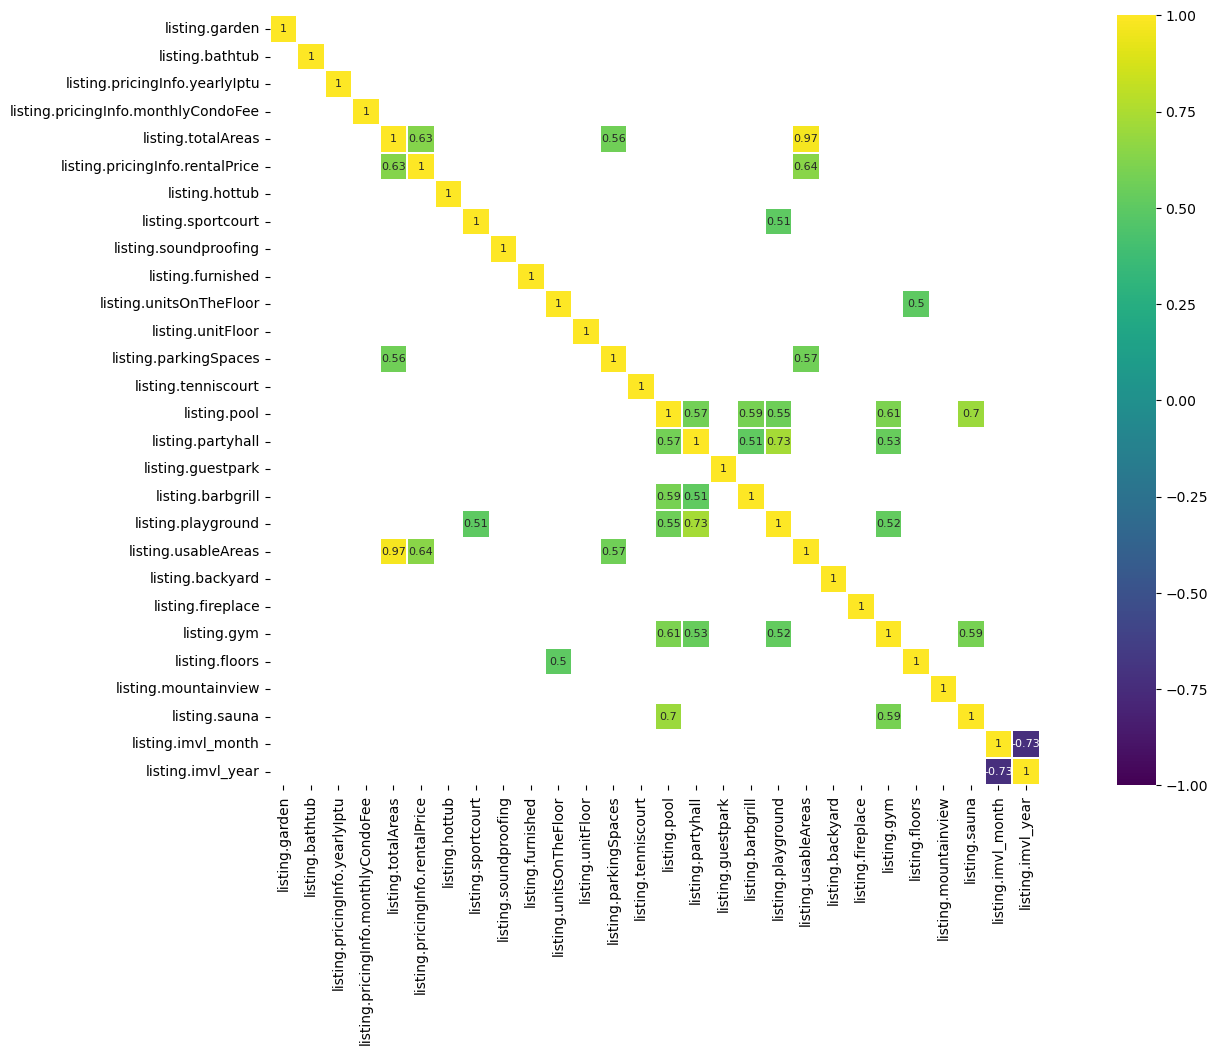

In [284]:
plt.subplots(figsize=(20, 10))
# sns.heatmap(df.corr(), cmap="RdBu", cbar=True, annot=True)
corr = df.corr()
sns.heatmap(
    corr[(corr >= 0.5) | (corr <= -0.4)],
    cmap="viridis",
    vmax=1.0,
    vmin=-1.0,
    linewidths=0.1,
    annot=True,
    annot_kws={"size": 8},
    square=True,
)

Valores com uma correlação considerável:

- listing_sauna x listing pool
- listing.playground x listing.sportcourt
- listing.pricinginfo.rentalPrice x listing.bedrooms
- listing.bathtub x listing.hottub
- listing.partyhall x listing.playground
- listing.pool x listing.barbgrill

Apesar de alguns terem valores de correlação alto, não considero retirar algumas colunas pois elas podem existir mesmo que a outra não exista, então é importante deixar pois são características diferentes.

#### Categorico para numérico

In [285]:
df.shape

(8148, 35)

In [286]:
# df["group.usableAreas"] = [
#     "0 a 100"
#     if x <= 100
#     else "101 a 150"
#     if x > 100 and x <= 150
#     else "151 a 200"
#     if x > 150 and x <= 200
#     else "201 a 250"
#     if x > 200 and x <= 250
#     else "251 a 300"
#     if x > 250 and x <= 300
#     else "301 a 350"
#     if x > 300 and x <= 350
#     else "351 a 400"
#     if x > 350 and x <= 400
#     else "401 a 450"
#     if x > 400 and x <= 450
#     else "451 a 500"
#     if x > 450 and x <= 500
#     else "acima 500"
#     for x in df["listing.usableAreas"]
# ]

In [287]:
bool_columns = [
    "listing.mountainview",
    "listing.sauna",
    "listing.sportcourt",
    "listing.hottub",
    "listing.fireplace",
    "listing.guestpark",
    "listing.soundproofing",
    "listing.gym",
    "listing.playground",
    "listing.partyhall",
    "listing.backyard",
    "listing.garden",
    "listing.barbgrill",
    "listing.furnished",
    "listing.tenniscourt",
    "listing.bathtub",
    "listing.pool",
]


# "listing.address.neighborhood" é tratado manualmente
cat_columns = [
    "listing.address.neighborhood",
    # "group.usableAreas",
    "listing.address.zone",
    "imvl_type",
    "listing.imvl_season",
]

ordinal_cat_columns = ["listing.suites", "listing.bedrooms", "listing.bathrooms"]

num_columns = [
    # "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.yearlyIptu",
    "listing.usableAreas",
    "listing.totalAreas",
    "listing.pricingInfo.monthlyCondoFee",
    "listing.unitFloor",
    "listing.unitsOnTheFloor",
    "listing.floors",
    "listing.parkingSpaces",
    "listing.imvl_month",
    "listing.imvl_year",
]

print(len(bool_columns))
print(len(cat_columns))
print(len(ordinal_cat_columns))
print(len(num_columns))

17
4
3
10


In [288]:
df["listing.bathrooms"].value_counts()

1     3341
2     2360
3     1358
4      630
5      269
6      101
0       38
7       29
8       10
9        5
11       4
10       2
12       1
Name: listing.bathrooms, dtype: int64

In [289]:
df[cat_columns]

,listing.address.neighborhood,listing.address.zone,imvl_type,listing.imvl_season
0,Leme,Zona Sul,apartamentos,Outono
1,Copacabana,Zona Sul,apartamentos,Outono
2,Ipanema,Zona Sul,apartamentos,Outono
3,Botafogo,Zona Sul,apartamentos,Outono
4,Copacabana,Zona Sul,apartamentos,Outono
...,...,...,...,...
8143,Tijuca,Zona Norte,casas-de-condominio,Inverno
8144,Tijuca,Zona Norte,apartamentos,Inverno
8145,Copacabana,Zona Sul,apartamentos,Inverno
8146,Recreio Dos Bandeirantes,Zona Oeste,apartamentos,Inverno


In [290]:
df["listing.address.zone"].value_counts()

Zona Oeste      2797
Zona Sul        2674
Zona Norte      2446
Zona Central     231
Name: listing.address.zone, dtype: int64

In [291]:
df["imvl_type"].value_counts()

apartamentos           5697
casas                  1069
cobertura               897
quitinetes              281
casas-de-condominio      89
flat                     64
casas-de-vila            48
studio                    3
Name: imvl_type, dtype: int64

In [292]:
# Categorical to numerical - cat_columns
freq = df["listing.address.neighborhood"].value_counts(normalize=True)
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].map(freq)

In [293]:
df = encode_categorical_columns(df, cat_columns)
df

,listing.garden,listing.suites,listing.bathtub,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.hottub,listing.sportcourt,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.parkingSpaces,listing.bathrooms,listing.tenniscourt,listing.pool,listing.partyhall,listing.guestpark,listing.barbgrill,listing.playground,listing.usableAreas,listing.backyard,listing.fireplace,listing.gym,listing.floors,listing.mountainview,listing.sauna,listing.imvl_month,listing.imvl_year,listing.address.neighborhood_0.00012272950417280314,listing.address.neighborhood_0.0002454590083456063,listing.address.neighborhood_0.0003681885125184094,listing.address.neighborhood_0.0004909180166912126,listing.address.neighborhood_0.0006136475208640157,listing.address.neighborhood_0.0007363770250368188,listing.address.neighborhood_0.000859106529209622,listing.address.neighborhood_0.0009818360333824251,listing.address.neighborhood_0.0011045655375552283,listing.address.neighborhood_0.0012272950417280314,listing.address.neighborhood_0.0013500245459008345,listing.address.neighborhood_0.0014727540500736377,listing.address.neighborhood_0.0015954835542464408,listing.address.neighborhood_0.001718213058419244,listing.address.neighborhood_0.001840942562592047,listing.address.neighborhood_0.0019636720667648502,listing.address.neighborhood_0.0022091310751104565,listing.address.neighborhood_0.0023318605792832597,...,listing.address.neighborhood_0.006136475208640157,listing.address.neighborhood_0.006381934216985763,listing.address.neighborhood_0.006872852233676976,listing.address.neighborhood_0.007241040746195386,listing.address.neighborhood_0.007609229258713795,listing.address.neighborhood_0.007731958762886598,listing.address.neighborhood_0.008468335787923416,listing.address.neighborhood_0.008836524300441826,listing.address.neighborhood_0.008959253804614629,listing.address.neighborhood_0.009204712812960236,listing.address.neighborhood_0.009572901325478646,listing.address.neighborhood_0.009941089837997054,listing.address.neighborhood_0.011536573392243496,listing.address.neighborhood_0.011782032400589101,listing.address.neighborhood_0.013745704467353952,listing.address.neighborhood_0.01485027000490918,listing.address.neighborhood_0.015586647029946,listing.address.neighborhood_0.01718213058419244,listing.address.neighborhood_0.01914580265095729,listing.address.neighborhood_0.019268532155130094,listing.address.neighborhood_0.02025036818851252,listing.address.neighborhood_0.024791359842906233,listing.address.neighborhood_0.02540500736377025,listing.address.neighborhood_0.027123220422189495,listing.address.neighborhood_0.027859597447226315,listing.address.neighborhood_0.029945999018163968,listing.address.neighborhood_0.03829160530191458,listing.address.neighborhood_0.03853706431026019,listing.address.neighborhood_0.048109965635738834,listing.address.neighborhood_0.05719194894452626,listing.address.neighborhood_0.0586647029945999,listing.address.neighborhood_0.08149239077074129,listing.address.neighborhood_0.10260186548846342,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio,listing.imvl_season_Inverno,listing.imvl_season_Outono,listing.imvl_season_Primavera,listing.imvl_season_Verão
0,False,1.0,False,142.000,550.0,50.0,2.65,False,False,False,True,0.0,5.0,1,0.0,2,False,False,False,False,False,False,50.0,False,False,False,12.0,False,False,5,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
1,False,0.0,False,109.000,850.0,50.0,2.30,False,False,False,True,0.0,0.0,1,0.0,1,False,False,False,False,False,False,50.0,False,False,False,

In [294]:
df[bool_columns]

,listing.mountainview,listing.sauna,listing.sportcourt,listing.hottub,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.garden,listing.barbgrill,listing.furnished,listing.tenniscourt,listing.bathtub,listing.pool
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8143,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
8144,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8145,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
8146,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [295]:
df[bool_columns] = df[bool_columns].astype(int)
df[bool_columns]

,listing.mountainview,listing.sauna,listing.sportcourt,listing.hottub,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.garden,listing.barbgrill,listing.furnished,listing.tenniscourt,listing.bathtub,listing.pool
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8143,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8145,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Explicar que o categorical columns aumenta muito a dimensionalidade e o desempenho do modelo e por isso foi utilizado outros métodos para transformar os dados categóricos em numericos

In [296]:
le = LabelEncoder()

for categorical in ordinal_cat_columns:
    df[categorical] = df[categorical].astype(str)
    df[categorical] = le.fit_transform(df[categorical])

#### Normalização dos Dados

In [297]:
df.head(2)

,listing.garden,listing.suites,listing.bathtub,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.hottub,listing.sportcourt,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.parkingSpaces,listing.bathrooms,listing.tenniscourt,listing.pool,listing.partyhall,listing.guestpark,listing.barbgrill,listing.playground,listing.usableAreas,listing.backyard,listing.fireplace,listing.gym,listing.floors,listing.mountainview,listing.sauna,listing.imvl_month,listing.imvl_year,listing.address.neighborhood_0.00012272950417280314,listing.address.neighborhood_0.0002454590083456063,listing.address.neighborhood_0.0003681885125184094,listing.address.neighborhood_0.0004909180166912126,listing.address.neighborhood_0.0006136475208640157,listing.address.neighborhood_0.0007363770250368188,listing.address.neighborhood_0.000859106529209622,listing.address.neighborhood_0.0009818360333824251,listing.address.neighborhood_0.0011045655375552283,listing.address.neighborhood_0.0012272950417280314,listing.address.neighborhood_0.0013500245459008345,listing.address.neighborhood_0.0014727540500736377,listing.address.neighborhood_0.0015954835542464408,listing.address.neighborhood_0.001718213058419244,listing.address.neighborhood_0.001840942562592047,listing.address.neighborhood_0.0019636720667648502,listing.address.neighborhood_0.0022091310751104565,listing.address.neighborhood_0.0023318605792832597,...,listing.address.neighborhood_0.006136475208640157,listing.address.neighborhood_0.006381934216985763,listing.address.neighborhood_0.006872852233676976,listing.address.neighborhood_0.007241040746195386,listing.address.neighborhood_0.007609229258713795,listing.address.neighborhood_0.007731958762886598,listing.address.neighborhood_0.008468335787923416,listing.address.neighborhood_0.008836524300441826,listing.address.neighborhood_0.008959253804614629,listing.address.neighborhood_0.009204712812960236,listing.address.neighborhood_0.009572901325478646,listing.address.neighborhood_0.009941089837997054,listing.address.neighborhood_0.011536573392243496,listing.address.neighborhood_0.011782032400589101,listing.address.neighborhood_0.013745704467353952,listing.address.neighborhood_0.01485027000490918,listing.address.neighborhood_0.015586647029946,listing.address.neighborhood_0.01718213058419244,listing.address.neighborhood_0.01914580265095729,listing.address.neighborhood_0.019268532155130094,listing.address.neighborhood_0.02025036818851252,listing.address.neighborhood_0.024791359842906233,listing.address.neighborhood_0.02540500736377025,listing.address.neighborhood_0.027123220422189495,listing.address.neighborhood_0.027859597447226315,listing.address.neighborhood_0.029945999018163968,listing.address.neighborhood_0.03829160530191458,listing.address.neighborhood_0.03853706431026019,listing.address.neighborhood_0.048109965635738834,listing.address.neighborhood_0.05719194894452626,listing.address.neighborhood_0.0586647029945999,listing.address.neighborhood_0.08149239077074129,listing.address.neighborhood_0.10260186548846342,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio,listing.imvl_season_Inverno,listing.imvl_season_Outono,listing.imvl_season_Primavera,listing.imvl_season_Verão
0,0,1,0,142.0,550.0,50.0,2.65,0,0,0,1,0.0,5.0,1,0.0,5,0,0,0,0,0,0,50.0,0,0,0,12.0,0,0,5,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,109.0,850.0,50.0,2.30,0,0,0,1,0.0,0.0,1,0.0,1,0,0,0,0,0,0,50.0,0,0,0,1.0,0,0,5,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0

In [298]:
df = standardize_columns(df, num_columns)
df.head(2)

,listing.garden,listing.suites,listing.bathtub,listing.pricingInfo.yearlyIptu,listing.pricingInfo.monthlyCondoFee,listing.totalAreas,listing.pricingInfo.rentalPrice,listing.hottub,listing.sportcourt,listing.soundproofing,listing.furnished,listing.unitsOnTheFloor,listing.unitFloor,listing.bedrooms,listing.parkingSpaces,listing.bathrooms,listing.tenniscourt,listing.pool,listing.partyhall,listing.guestpark,listing.barbgrill,listing.playground,listing.usableAreas,listing.backyard,listing.fireplace,listing.gym,listing.floors,listing.mountainview,listing.sauna,listing.imvl_month,listing.imvl_year,listing.address.neighborhood_0.00012272950417280314,listing.address.neighborhood_0.0002454590083456063,listing.address.neighborhood_0.0003681885125184094,listing.address.neighborhood_0.0004909180166912126,listing.address.neighborhood_0.0006136475208640157,listing.address.neighborhood_0.0007363770250368188,listing.address.neighborhood_0.000859106529209622,listing.address.neighborhood_0.0009818360333824251,listing.address.neighborhood_0.0011045655375552283,listing.address.neighborhood_0.0012272950417280314,listing.address.neighborhood_0.0013500245459008345,listing.address.neighborhood_0.0014727540500736377,listing.address.neighborhood_0.0015954835542464408,listing.address.neighborhood_0.001718213058419244,listing.address.neighborhood_0.001840942562592047,listing.address.neighborhood_0.0019636720667648502,listing.address.neighborhood_0.0022091310751104565,listing.address.neighborhood_0.0023318605792832597,...,listing.address.neighborhood_0.006136475208640157,listing.address.neighborhood_0.006381934216985763,listing.address.neighborhood_0.006872852233676976,listing.address.neighborhood_0.007241040746195386,listing.address.neighborhood_0.007609229258713795,listing.address.neighborhood_0.007731958762886598,listing.address.neighborhood_0.008468335787923416,listing.address.neighborhood_0.008836524300441826,listing.address.neighborhood_0.008959253804614629,listing.address.neighborhood_0.009204712812960236,listing.address.neighborhood_0.009572901325478646,listing.address.neighborhood_0.009941089837997054,listing.address.neighborhood_0.011536573392243496,listing.address.neighborhood_0.011782032400589101,listing.address.neighborhood_0.013745704467353952,listing.address.neighborhood_0.01485027000490918,listing.address.neighborhood_0.015586647029946,listing.address.neighborhood_0.01718213058419244,listing.address.neighborhood_0.01914580265095729,listing.address.neighborhood_0.019268532155130094,listing.address.neighborhood_0.02025036818851252,listing.address.neighborhood_0.024791359842906233,listing.address.neighborhood_0.02540500736377025,listing.address.neighborhood_0.027123220422189495,listing.address.neighborhood_0.027859597447226315,listing.address.neighborhood_0.029945999018163968,listing.address.neighborhood_0.03829160530191458,listing.address.neighborhood_0.03853706431026019,listing.address.neighborhood_0.048109965635738834,listing.address.neighborhood_0.05719194894452626,listing.address.neighborhood_0.0586647029945999,listing.address.neighborhood_0.08149239077074129,listing.address.neighborhood_0.10260186548846342,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio,listing.imvl_season_Inverno,listing.imvl_season_Outono,listing.imvl_season_Primavera,listing.imvl_season_Verão
0,0,1,0,0.193460,0.314145,0.165541,2.65,0,0,0,1,0.0,0.0625,1,0.0,5,0,0,0,0,0,0,0.121212,0,0,0,0.068571,0,0,0.363636,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0.148501,0.560855,0.165541,2.30,0,0,0,1,0.0,0.0000,1,0.0,1,0,0,0,0,0,0,0.121212,0,0,0,0.005714,0,0,0.363636,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,

#### Save 2

In [299]:
df.to_csv("./dataZap_normalized.csv", sep=";", index=False)

### Divisão Treino e Teste

In [329]:
df = pd.read_csv("dataZap_normalized.csv", delimiter=";")
df.shape

(8148, 119)

In [330]:
df.shape

(8148, 119)

In [331]:
X = df.drop(["listing.pricingInfo.rentalPrice"], axis=1)
y = df["listing.pricingInfo.rentalPrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Regressões

#### Regressão Linear

With pd.dummies categorizer / onehotencoder

In [303]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

In [304]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.7555
MAE 		: 1.8508
MSE 		: 8.4898
RMSE 		: 2.9137


#### Regressão Ridge

In [305]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [306]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.7557
MAE 		: 1.8479
MSE 		: 8.4823
RMSE 		: 2.9124


#### Regressão Lasso

In [307]:
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

In [308]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.3598
MAE 		: 2.9144
MSE 		: 22.2266
RMSE 		: 4.7145


#### Regressão ElasticNet

In [309]:
elasticnet_model = ElasticNet(alpha=1.0)
elasticnet_model.fit(X_train, y_train)
y_pred = elasticnet_model.predict(X_test)

In [310]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.3724
MAE 		: 2.8909
MSE 		: 21.7911
RMSE 		: 4.6681


#### Regressão Logística

Não é possível fazer regressão logística com esse dataset

#### Regressão com KNN

In [311]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [312]:
y_pred = knn_model.predict(X_test)
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.77
MAE 		: 1.4229
MSE 		: 7.9868
RMSE 		: 2.8261


#### Regressão com Árvore

In [313]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [314]:
y_pred = decision_tree_model.predict(X_test)
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.7227
MAE 		: 1.4395
MSE 		: 9.6288
RMSE 		: 3.103


#### Resultado Final das Regressões

In [332]:
models = [
    "LinearRegression",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "KNeighborsRegressor",
    "DecisionTreeRegressor",
]
results = {}

for model in models:
    mse, rmse, r2, mae, best_params = evaluate_regression_metrics(
        model, X_train, y_train, X_test, y_test
    )
    results[model] = {
        "R2": round(r2, 4),
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
    }

results_df = pd.DataFrame(results).T
results_df.index.name = "Model"
results_df

,R2,MSE,RMSE,MAE
Model,,,,
LinearRegression,0.7555,8.4898,2.9137,1.8508
Ridge,0.7557,8.4823,2.9124,1.8479
Lasso,0.7060,10.2089,3.1951,2.0240
ElasticNet,0.6824,11.0258,3.3205,2.1093
KNeighborsRegressor,0.7931,7.1840,2.6803,1.2963
DecisionTreeRegressor,0.7832,7.5262,2.7434,1.3483


#### Melhor Modelo de Regressão

In [333]:
mse, rmse, r2, mae, best_params = evaluate_regression_metrics(
    "KNeighborsRegressor", X_train, y_train, X_test, y_test
)

In [334]:
knn_model = KNeighborsRegressor(**best_params)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
y_pred = np.round(y_pred, decimals=3)
df_final = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_pred.flatten()})
df_final

,Actual,Predicted
0,2.6,3.530
1,1.6,1.195
2,3.5,2.697
3,4.9,5.337
4,13.0,9.765
...,...,...
1625,1.3,1.300
1626,15.0,21.978
1627,1.7,1.589
1628,1.6,2.212


### Classificação

In [319]:
df = pd.read_csv("dataZap_normalized.csv", delimiter=";")
df.shape

(8148, 119)

In [320]:
df["listing.pricingInfo.rentalPrice"].unique()

array([ 2.65 ,  2.3  ,  4.7  ,  2.7  ,  1.7  ,  2.   ,  1.4  ,  2.8  ,
        2.1  ,  2.2  ,  1.25 ,  1.3  ,  1.5  ,  3.5  ,  3.2  ,  2.99 ,
        3.8  ,  1.405,  2.5  ,  1.2  ,  1.6  ,  1.92 ,  3.   ,  4.5  ,
        3.7  ,  1.1  ,  1.55 ,  1.17 ,  2.4  ,  1.9  ,  1.649,  1.47 ,
        1.   ,  3.1  ,  2.93 ,  2.55 ,  1.903,  2.68 ,  1.31 ,  1.8  ,
        1.184,  2.555,  3.6  ,  1.15 ,  1.058,  1.48 ,  1.997,  4.6  ,
        2.415,  1.575,  4.8  ,  1.642,  1.344,  1.65 ,  2.95 ,  2.6  ,
        1.579,  1.22 ,  1.18 ,  2.9  ,  5.   ,  1.23 ,  4.   ,  1.105,
        1.103,  6.5  ,  1.99 ,  1.175,  1.36 ,  1.05 ,  2.25 ,  1.835,
        1.75 ,  1.72 ,  1.375,  1.962,  1.01 ,  3.4  ,  1.685,  5.5  ,
        4.2  ,  1.26 ,  4.3  ,  1.35 ,  1.95 ,  1.393,  1.69 ,  1.698,
        2.04 ,  1.469,  5.8  ,  1.14 ,  1.459,  2.24 ,  5.4  ,  1.275,
        1.38 ,  3.9  ,  1.044,  2.37 ,  1.45 ,  1.06 ,  1.24 ,  1.02 ,
        1.93 ,  1.19 ,  1.345,  2.393,  3.3  ,  2.811,  2.43 ,  6.8  ,
      

In [321]:
df["target.listing.pricingInfo.rentalPrice"] = df[
    "listing.pricingInfo.rentalPrice"
].apply(define_classification)
df.drop(columns="listing.pricingInfo.rentalPrice", inplace=True)

In [322]:
df["target.listing.pricingInfo.rentalPrice"].value_counts()

MEDIO    4164
BAIXO    2003
ALTO     1981
Name: target.listing.pricingInfo.rentalPrice, dtype: int64

In [323]:
X = df.drop(["target.listing.pricingInfo.rentalPrice"], axis=1)
y = df["target.listing.pricingInfo.rentalPrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [324]:
models = [
    "LogisticRegression",
    "RandomForest",
    "SVM",
    "KNeighborsClassifier",
    "DecisionTreeClassifier",
]
results = {}

for model in models:
    accuracy, precision, recall, f1, best_params = evaluate_classification_metrics(
        model, X_train, y_train, X_test, y_test, average="macro"
    )
    results[model] = {
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-score": round(f1, 4),
    }

results_df = pd.DataFrame(results).T
results_df.index.name = "Model"
results_df

,Accuracy,Precision,Recall,F1-score
Model,,,,
LogisticRegression,0.8055,0.8012,0.7993,0.8002
RandomForest,0.8264,0.8258,0.8147,0.8200
SVM,0.8221,0.8176,0.8241,0.8199
KNeighborsClassifier,0.7914,0.7890,0.7886,0.7880
DecisionTreeClassifier,0.7914,0.7925,0.7891,0.7890


#### Melhor Modelo de Classificação

In [325]:
accuracy, precision, recall, f1, best_params = evaluate_classification_metrics(
    "RandomForest", X_train, y_train, X_test, y_test
)

In [326]:
best_params

{'max_depth': None, 'n_estimators': 300}

In [327]:
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
df_final = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_pred.flatten()})
df_final

,Actual,Predicted
0,MEDIO,MEDIO
1,MEDIO,BAIXO
2,MEDIO,MEDIO
3,MEDIO,MEDIO
4,ALTO,ALTO
...,...,...
1625,BAIXO,BAIXO
1626,ALTO,ALTO
1627,MEDIO,MEDIO
1628,MEDIO,MEDIO


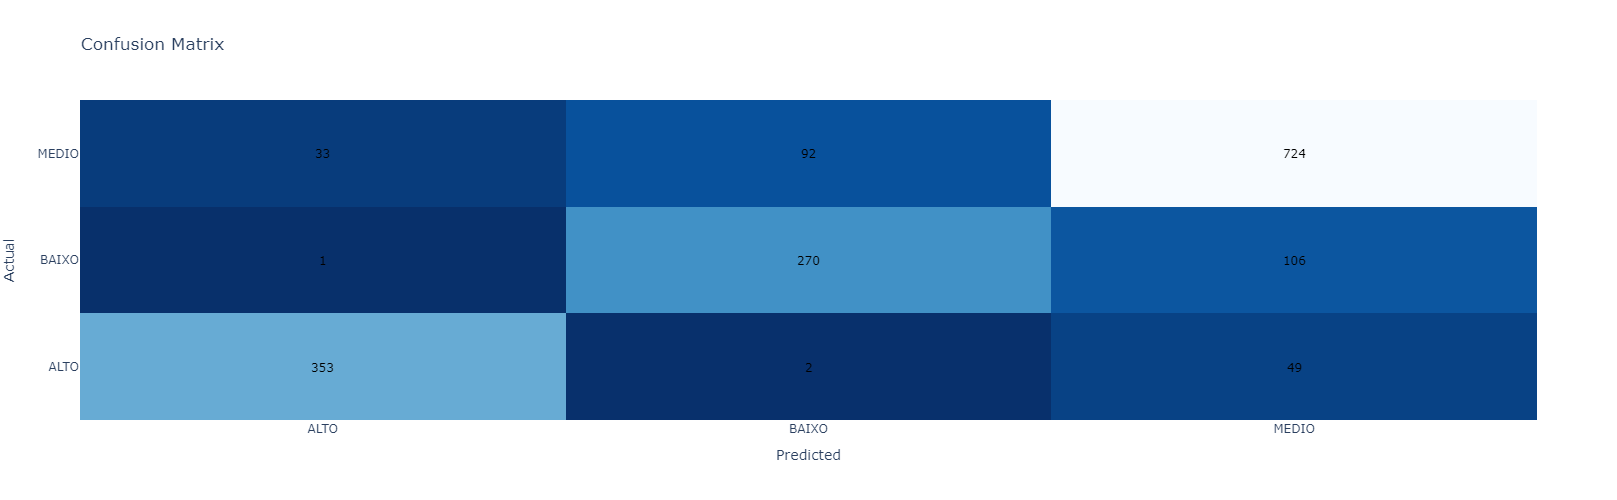

In [328]:
plot_confusion_matrix(model, X_test, y_test)

### Next Steps

- Aumentar os dados para analisar o desempenho dos modelos
- Feature Selection / Feature Importance: apesar de realizar a matriz de correlação e utilizar o RFE, acredito que possa ter um processo que melhore o desempenho quando altera o tamanho das colunas (para melhor)
- Gráficos
- Utilizar a data e criar novas colunas para dia, mes, ano e estação do ano para analisar o desempenho